### MountainCar Using Q-Learning- Here, intention is to move the car past the top flag with increased bins

In [11]:
# import necessary libraries module
import gymnasium as gym
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

#### Creating the Agent environment

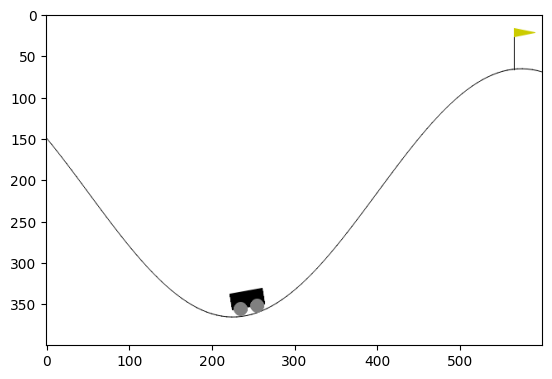

In [12]:
# make the env
# Again, it can seen that there is issue 
# of inability to adapt to random starting conditions
# which could be handled by a training learned policy.
# It actually started at a position -0.44
# then to like -0.51 after 3 trials
env = gym.make("MountainCar-v0", render_mode='rgb_array')

# visualize the environment
env.reset()
plt.imshow(env.render()) 

In [13]:
# observation space
# the position is between -1.2 to 0.6
# the velocity is between -0.07 to 0.07
env.observation_space

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

#### Need to create the bins for the position and velocity

In [14]:
# helper variables
# Here, I started 30 and 20 to see
# how better the accuracy works out
num_position_bins = 50
num_velocity_bins = 30

# for calculating the needed steps in the bins
max_position = env.observation_space.high[0]
min_position = env.observation_space.low[0]
max_velocity = env.observation_space.high[1]
min_velocity = env.observation_space.low[1]

# create the bins for position and velocity separately
# first step, create the ranges between the bins by using LINSPACE
position_bins = np.linspace(min_position, max_position, num_position_bins)
velocity_bins = np.linspace(min_velocity, max_velocity, num_velocity_bins)

# second step, use NumPy's digitize in order to discretize our state space
# positions = np.digitize(position_bins, bins=position_bins) - 1
# velocities = np.digitize(velocity_bins, bins=velocity_bins) - 1

In [15]:
max_position, min_velocity

(np.float32(0.6), np.float32(-0.07))

In [16]:
max_velocity, min_velocity

(np.float32(0.07), np.float32(-0.07))

In [17]:
# how many states will we have in total
num_states = num_position_bins * num_velocity_bins
print(f"Number of possible states in Q-table: {num_states}")

Number of possible states in Q-table: 1500


#### Here, I created the Q-table with the help of the bins

In [18]:
# create the Q-table
Q_table = np.zeros((num_position_bins, num_velocity_bins, env.action_space.n))
Q_table.shape

(50, 30, 3)

#### Creating a helper function that update the Q-table

In [19]:
# The Q-table update the function that stores 
# both position and velocity values
# (the index values have to match in both)
def calculate_value(Q, state, action, reward, next_state, alpha, gamma):
    # keeping both position and velocity values
    # state[0] = position, state[1] = velocity
    Q[state[0], state[1], action] = Q[state[0], state[1], action] + alpha * (reward + gamma * np.max(Q[next_state[0], next_state[1]]) - Q[state[0], state[1], action])
    return Q

In [20]:
# A helper function => as the environment gives all the observations
# (velocity and positions) in the original format, and then discretize the 
# position and velocity instantly.
# This maps the real values into the bins
# for example: 30 for position, 20 for velocity which are 
# the correct bin for both position and velocity
def get_state(observation):
    position = np.digitize(observation[0], bins=position_bins) - 1
    velocity = np.digitize(observation[1], bins=velocity_bins) - 1
    return position, velocity

### The Hyperparameters

In [21]:
# total training episodes, in this case, 15000 should do
total_episodes = 15000

# this environment is probably solvable in 100-200 steps
# the max_steps= 200
max_steps = 200

# learning rate => 0.2 (to make milder updates)
# you can experiment probably between 0.1 and 0.5
learning_rate = 0.2

# The need to encourage long term reward 
# because we only wish our car to get past the flag
gamma = 0.99

# exploration parameters
epsilon = 0.9

# upper bound of our epsilon
max_epsilon = 0.9

# this is the lower bound, and our code is not going to decay the epsilon below this
# we can actually disable the whole epsilon in this case in the end
min_epsilon = 0.0

# ramping up the decay rate for faster switch to using the
# Q-table instead of guessing too much
decay_rate = 0.003

### The training Agent model loop- Q-learning

### Also, I noticed with the below parameters the Agent model actually learnt nothing. As there was no output at all for nearlly almost 3 minutes training .

###  The hyperparameters gamma=0.99, total_episodes=15000, max_steps= 100, learning_rate=0.5. So, I think the learning_rate need to be reduced. So I comment it out


###  With the hyperparameters gamma=0.9, total_episodes=10000, max_steps= 50, learning_rate=0.2
 
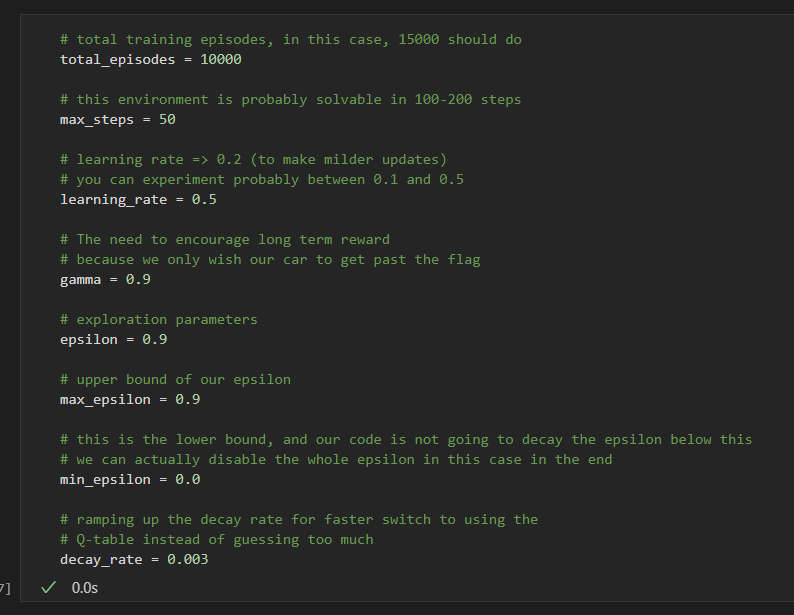



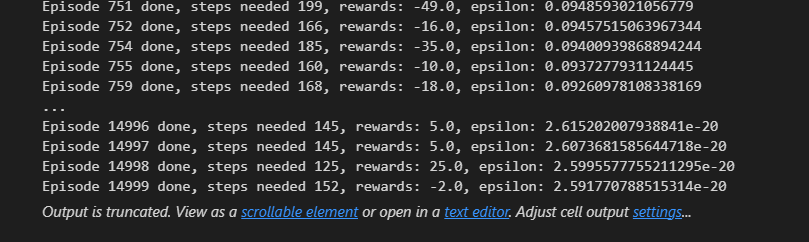

In [22]:
# for visualizing our reward progress while training
rewards = []

# "play" the game for the amount episodes defined
for episode in range(total_episodes):
    # get initial state
    state, info = env.reset()

    # And the state (current, old, new)
    # are discretize it with functions
    state = get_state(state)

    # in the beginning of the game, the game is not over
    # the game is done either by falling into a hole or finding the goal
    done = False

    # in the beginning of the game, total_rewards are 0
    total_rewards = 0

    # Here, the game started playing 
    for step in range(max_steps):

        # exploration/exploitation
        if np.random.uniform(0, 1) > epsilon:
            # use exploitation in this case => use best known action for this cell!
            # fix this to use correct format
            action = np.argmax(Q_table[state[0], state[1]])
        else:
            # let's explore => random action
            action = env.action_space.sample()

        # gtinget the results from the action done from above
        # and unpack the results into: observation, reward, done
        new_state, reward, done, truncated, info = env.step(action)

        # get the current state
        position = new_state[0]

        # convert the current observation into our bins
        new_state = get_state(new_state)

        # let's see if we have solved the environment => we have driven past the flag
        if done and position >= 0.5:
            reward = 150
            Q_table = calculate_value(Q_table, state, action, reward, new_state, learning_rate, gamma)
            total_rewards += reward
            print(f"Episode {episode} done, steps needed {step}, rewards: {total_rewards}, epsilon: {epsilon}")
            break

        # This then update the Q-table with the values we have right now
        Q_table = calculate_value(Q_table, state, action, reward, new_state, learning_rate, gamma)

        # saving the current state and update rewards
        state = new_state
        total_rewards = total_rewards + reward

    # for visualization purposes, let's collect the rewards into a list
    rewards.append(total_rewards)        

    # Then, apply decay to epsilon
    # instead of linear decay, we have an expontential curve
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

Episode 1237 done, steps needed 171, rewards: -21.0, epsilon: 0.022073874575305984
Episode 1294 done, steps needed 183, rewards: -33.0, epsilon: 0.018604337702174577
Episode 1342 done, steps needed 161, rewards: -11.0, epsilon: 0.016109268077068913
Episode 1350 done, steps needed 180, rewards: -30.0, epsilon: 0.015727248218301657
Episode 1376 done, steps needed 170, rewards: -20.0, epsilon: 0.014547145129349287
Episode 1389 done, steps needed 182, rewards: -32.0, epsilon: 0.013990727144206797
Episode 1392 done, steps needed 186, rewards: -36.0, epsilon: 0.013865375528302764
Episode 1407 done, steps needed 171, rewards: -21.0, epsilon: 0.013255264089727731
Episode 1408 done, steps needed 175, rewards: -25.0, epsilon: 0.01321555788654297
Episode 1411 done, steps needed 173, rewards: -23.0, epsilon: 0.01309715149357451
Episode 1451 done, steps needed 169, rewards: -19.0, epsilon: 0.011616131322431876
Episode 1474 done, steps needed 199, rewards: -49.0, epsilon: 0.010841645282517758
Episod

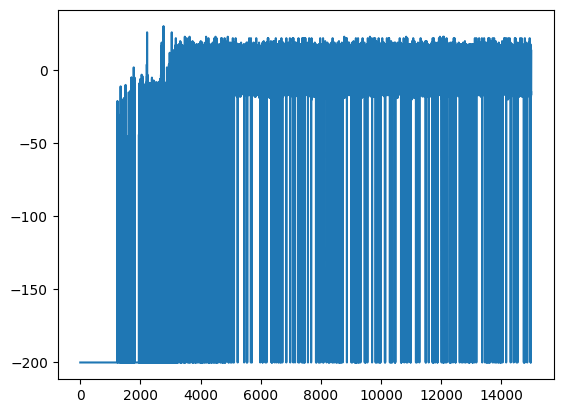

In [23]:
# let's see the rewards progression
plt.plot(rewards)
plt.show()

#### Pretty obvious the Agent model learnt absolute nothing for the 1 minute plus and started learning after 4100 plus total episodes. And can seen that it learnt then stop learning at every few total episodes. However, towards the end the Agent model could be seen pretty well learning. 

### Quite flunctuating every now and then I think

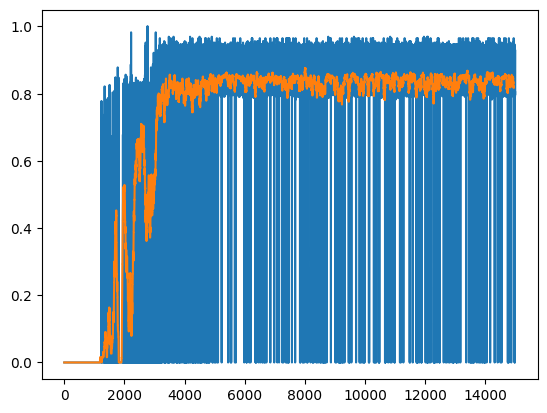

In [ ]:
# convert the rewards -list into NumPy -array format
rewards_arr = np.array(rewards)

# define a window size for a moving average

# Setting the window size 
# 15000 => 30-50 is okay for window size
window_size = 50

# normalize the rewards (manual MinMax -normalization)
normalized_rewards = (rewards_arr - min(rewards_arr)) / (max(rewards_arr) - min(rewards_arr))

# calculate the running mean
running_mean = np.convolve(normalized_rewards, np.ones(window_size) / window_size, mode="valid")

# visualize rewards + RUNNING MEAN
plt.plot(normalized_rewards)
plt.plot(running_mean)
plt.show()

### I doubt if the Agent actually learn to retain any past experience but worth trying out to see how it will park the car.

##Now, the Agent is trained to play and park the car past the flag

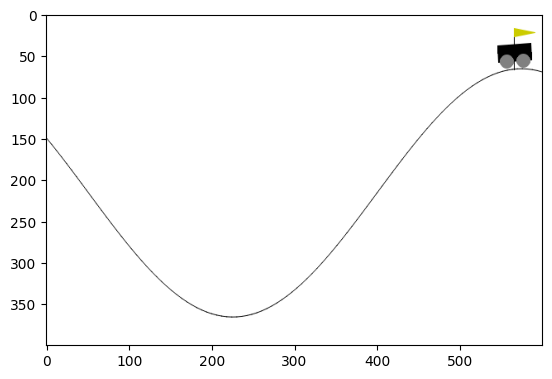

Episode: 3 done with total_rewards: -157.0


In [ ]:
# let's use now the Q-table (agent) we have for this environment
# => play the game based on the Q-table but only using exploitation

total_test_episodes = 3

env.reset()
clear_output(wait=True)
plt.imshow(env.render())
plt.show()

# for-loop => allow the agent to play this 5 times in a row (5 episodes)
for episode in range(total_test_episodes):
    state, info = env.reset()
    state = get_state(state)
    done = False
    total_rewards = 0

    # play for the max number of steps
    for step in range(max_steps):
        # best action is into consideration from the Q-table
        # the best action is chosen
        # in the Q-table during training

        # Here, choosing a random path is important
        # in case of a multiple identifier
        action = np.argmax(Q_table[state[0], state[1]])

        # unpack the results
        observation, reward, done, truncated, info = env.step(action)
        observation = get_state(observation)

        # update total rewards
        total_rewards = total_rewards + reward

        # update the visual frame
        clear_output(wait=True)
        plt.imshow(env.render())
        plt.show()

        # if we are game over either by hole or goal => break the loop
        if done:
            print(f"Episode: {episode + 1} done with total_rewards: {total_rewards}")
            time.sleep(2)
            break

        # save new state as old state, continue with next step
        state = observation
        # time.sleep(0.3)

env.close()

### My observation:

### I think fewer bins made the agent to learn by exploring and then updates the Q-values with few states. Which I think its due to lower memory usage that leads to loss of precision and the quite low optimal policy. That it may or not learn any best possible means to move past the flag.
### And led to poor perfomance which means the need to increase the number of the bins for both position and the velocity. And adjusting the hyperparameters too.